In [39]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics


# Load saved data

In [2]:
os.getcwd()
os.chdir(r"D:\sep22_10_supply_chain\data")

In [3]:
data_en = pd.read_pickle(r"data_en.pickle")

In [4]:
data_en.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,language,processed_reviews
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,EN,use elit danger mac amaz joystick especi love ...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,EN,love even realis game mous type silent mous se...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,EN,poor qualiti advertis
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,EN,nice tend slip away stick intens hard press ga...
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,EN,great amiibo great collect qualiti materi desi...


# Split data into train, test and val

In [5]:
X_train, X_test_val, y_train, y_test_val = train_test_split(data_en.processed_reviews, data_en.star_rating, test_size= 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, random_state=42)

# Illustrate class imbalance

Text(0.5, 1.0, 'Rating distribution for samples')

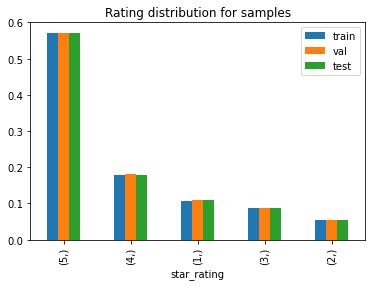

In [6]:
pd.concat([pd.DataFrame(x).value_counts(normalize=1) for x in [y_train, y_val, y_test]], axis=1).rename({0:"train", 1:"val", 2:"test"}, axis=1).plot(kind="bar")
plt.title("Rating distribution for samples")


# Vectorization

Idea: Define a function performing vectorization, to make it easy to add other methods

In [7]:
def tf_idf_transformer(X_train, X_val):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    X_train_counts.shape
    #tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
    #X_train_tf = tf_transformer.transform(X_train_counts)
    #X_train_tf.shape
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    #X_train_tfidf.shape
    X_val_tfidf = count_vect.transform(X_val)
    X_val_tfidf = tfidf_transformer.transform(X_val_tfidf)    

    return X_train_tfidf, X_val_tfidf


In [8]:
X_train_vectorized, X_val_vectorized = tf_idf_transformer(X_train, X_val)

# Classification

In [37]:
clf_mnNB = MultinomialNB().fit(X_train_vectorized, y_train)


In [43]:
clf_knn = KNeighborsClassifier(n_neighbors=100).fit(X_train_vectorized, y_train)


In [ ]:
# Assessement of results

In [34]:
def assess_on_val(clf, X_val_vectorized, y_val):
    predicted = clf.predict(X_val_vectorized)
    total_accuracy = metrics.accuracy_score(predicted, y_val)

    accuracy_by_rating_class = {rc : metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc]) for rc in data_en.star_rating.unique()}
    accuracy_by_rating_class = pd.DataFrame.from_dict(accuracy_by_rating_class, orient="index")

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(131)
    accuracy_by_rating_class.sort_index().plot(kind = "bar", ax = ax)
    ax.set_title("Accuracy per  \nrating class")
    ax.axhline(y = total_accuracy, color ='r', linestyle = '--')
    ax.get_legend().remove()
    ax.set_ylim(0,1)

    ax2 = fig.add_subplot(132)
    pd.DataFrame({"star_rating": predicted}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax2)
    ax2.set_title("Percentage of \n predicted rating class")
    ax2.get_legend().remove()
    ax2.set_ylim(0,1)

    ax3 = fig.add_subplot(133)
    pd.DataFrame({"star_rating": y_val}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax3)
    ax3.set_title("Percentage of actual \n rating classes in val")
    ax3.get_legend().remove()
    ax3.set_ylim(0,1)
    return fig





#metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc])

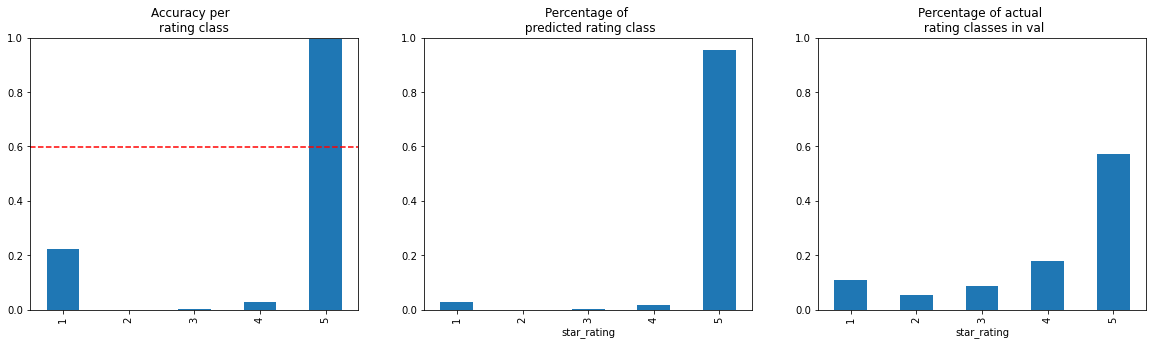

In [38]:

assess_on_val(clf_mnNB, X_val_vectorized, y_val);



In [44]:
assess_on_val(clf_knn, X_val_vectorized, y_val);